In [2]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
print(type(model))

model.eval()

<class 'timm.models.mlp_mixer.MlpMixer'>


MlpMixer(
  (stem): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): Sequential(
    (0): SpatialGatingBlock(
      (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp_channels): GatedMlp(
        (fc1): Linear(in_features=256, out_features=1536, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (gate): SpatialGatingUnit(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (proj): Linear(in_features=196, out_features=196, bias=True)
        )
        (fc2): Linear(in_features=768, out_features=256, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
    )
    (1): SpatialGatingBlock(
      (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp_channels): GatedMlp(
        (fc1): Linear(in_features=256, out_features=1536, bias=True)
        (act): GELU(app

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

heatmap
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FE176C97220>


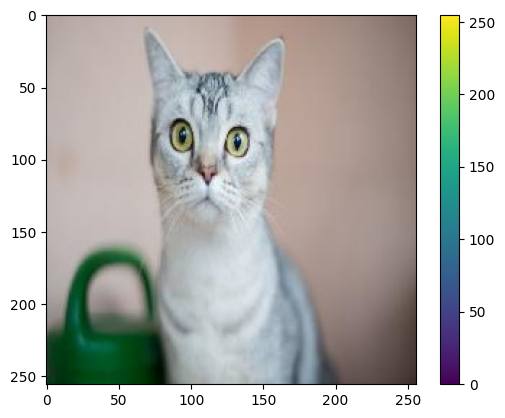

In [12]:
img = Image.open("cat.jpg")
exchange.show_heatmap_with_colorbar(img)
inputs = transform(img)
inputs = inputs.unsqueeze(0)

In [6]:
#推論
output = model(inputs)

forwrad
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([1, 196, 256])


In [7]:
block_inputs = []
block_outputs = []
#ブロックの入出力の抽出
for i in model.blocks:
    _input = i.block_input
    #_output = i.block_output
    block_inputs.append(_input)
    #block_outputs.append(_output)
    #print(type(_input), _input.shape)
    #print(type(_output), _output.shape)

<class 'numpy.ndarray'>
heatmap
[[ 0.04417498 -0.00338708  0.01266336 ...  0.03579836  0.05489355
   0.02997527]
 [-0.0262906   0.03872324  0.01042949 ...  1.66240025  0.01569492
   0.0246768 ]
 [ 0.00679865 -0.00249394  0.00529278 ...  0.03009628  0.03987977
   0.03417593]
 ...
 [ 0.08877172 -0.36282557  0.36207286 ...  0.03356148  0.04836332
   0.20689964]
 [-0.87432611  0.01621613 -0.35608754 ...  0.01125182  0.00948949
   0.0248719 ]
 [-0.44046202 -0.08639965 -0.34883934 ... -0.08629153  0.04695334
   0.02783438]]


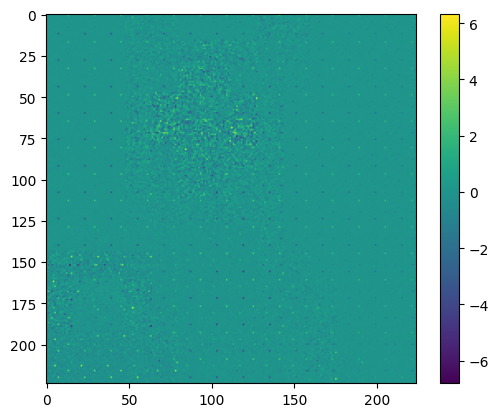

In [8]:
for i in block_inputs[0]:
    tmp = exchange.exchange_tensor_to_array(i[0])
    print(type(tmp))
    exchange.show_heatmap_with_colorbar(tmp)
    break
    #print(type(tmp), tmp.shape)
    tmp_output = model.pooling_only(i)
    print(type(tmp_output), tmp_output.shape)